In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import random
from sklearn.cluster import KMeans

In [2]:
from src import CompositeMask

In [3]:
test_img = 'data/test/Creatures-of-Comfort-spring-2018-look018.jpg'
seg_img = 'data/segmented/Creatures-of-Comfort-spring-2018-look018-seg.jpg'


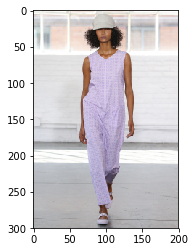

In [4]:
cm = CompositeMask(test_img, 0.3, 16)
#show an original runway image, resized to 200x300
cm.show_orig_image()

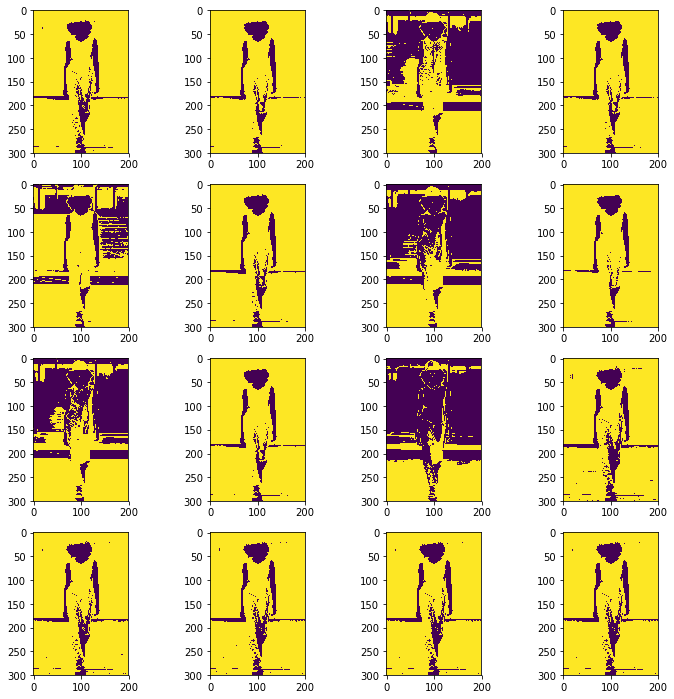

In [5]:
#take random samples from background (4x4 squares) and remove colors within that range from image
cm.plot_many_masks_bg()


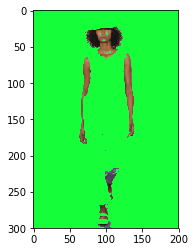

In [6]:
#combine all subtractions to create a composite mask
cm.show_masked_image()

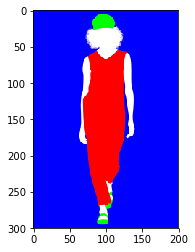

In [7]:
#for testing, compare to a manually segmented image.
#This image has been separated into garment, hair/skin, accessories, and background. 
#However, at this point I am only trying to isolate the figure from the background
seg_img = CompositeMask(seg_img).image
plt.imshow(seg_img)
plt.show()





In [10]:
#use OpenCV create a boolean mask by identifying all blue areas of the image
#true blue is [0, 0, 255]; we want to catch a range just in case
def make_boolean_mask(segmented_img):
    low_bg = np.array([0, 0, 250])
    high_bg = np.array([5, 5, 255])
    return cv2.inRange(segmented_img, low_bg, high_bg)



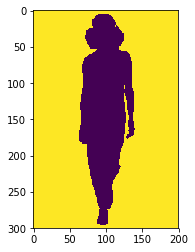

In [11]:
bg_is_255 = make_boolean_mask(seg_img)
plt.imshow(bg_is_255)
plt.show()

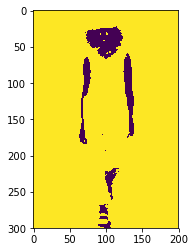

In [12]:
def cleanup_comp_mask(comp_mask):
    temp = np.array([255 if p > 127 else 0 for p in comp_mask.flatten()])
    return temp.reshape(300, 200)

#push any noisy pixels to 255 or 0
clean_comp_mask = cleanup_comp_mask(cm.full_composite_mask)
plt.imshow(clean_comp_mask)
plt.show()


In [13]:
def build_comp_image_and_confusion_dict(image_mask, manual_mask):
    '''
    compares predictions (composite mask) to truth (segmented mask)
    returns a new image with 4 levels: 255 for true background predictions 
                                       200 for figure predicted to be background
                                       100 for background predicted to be figure
                                       0 for true figure predictions
    
    a dict represention of a confusion matrix
    '''
    
    confusion_dict = {'true_bg_pred_bg': 0, 'true_bg_pred_fig': 0, 'true_fig_pred_bg': 0, 'true_fig_pred_fig': 0}
    new_image = []
    for row_manual, row_cm in zip(manual_mask, image_mask):
        for item_manual, item_cm in zip(row_manual, row_cm):
            if item_manual == item_cm :
                if item_manual == 255:
                    new_image.append(255)
                    confusion_dict['true_bg_pred_bg'] += 1
                else: 
                    new_image.append(0) 
                    confusion_dict['true_fig_pred_fig'] += 1
            else: 
                if item_manual > 200:
                    new_image.append(100)
                    confusion_dict['true_bg_pred_fig'] += 1
                else: 
                    new_image.append(200)
                    confusion_dict['true_fig_pred_bg'] += 1
                    
    return np.array(new_image).reshape(300, 200), confusion_dict
    

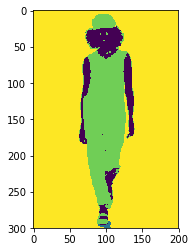

In [14]:
im, cd = build_comp_image_and_confusion_dict(clean_comp_mask, bg_is_255)
plt.imshow(im)
plt.show()

In [15]:
print cd

{'true_fig_pred_fig': 3702, 'true_fig_pred_bg': 10297, 'true_bg_pred_bg': 45922, 'true_bg_pred_fig': 79}


In [16]:
def get_comparison_metrics(confusion_dict):
    accuracy = (confusion_dict['true_bg_pred_bg'] + confusion_dict['true_fig_pred_fig']) / 60000.0
    precision_of_fig = (confusion_dict['true_fig_pred_fig'] + 1)*1. / \
            (confusion_dict['true_bg_pred_fig'] + confusion_dict['true_fig_pred_fig'] + 1)
    recall_of_fig = (confusion_dict['true_fig_pred_fig'] + 1)*1. / \
        (confusion_dict['true_fig_pred_bg'] + confusion_dict['true_fig_pred_fig'] + 1)
    harmonic_mean = 2.*(precision_of_fig * recall_of_fig) / (precision_of_fig + recall_of_fig)
    string_out = 'accuracy: ' + str(accuracy) + '\n'
    string_out += 'precision: ' + str(precision_of_fig) + '\n'
    string_out += 'recall: ' + str(recall_of_fig) + '\n'
    string_out += 'harmonic mean: ' + str(harmonic_mean)
    return accuracy, precision_of_fig, recall_of_fig, harmonic_mean, string_out
    

In [17]:
print get_comparison_metrics(cd)[4]

accuracy: 0.827066666667
precision: 0.979111581174
recall: 0.2645
harmonic mean: 0.416488583961


In [26]:
def from_paths_to_conf_dict(path_to_orig, path_to_manual_seg, threshold, num_bg_pts):
    
    fig = plt.figure(figsize=(8, 3))
    
    #create composite mask object
    cm = CompositeMask(path_to_orig, threshold, num_bg_pts)
    comp_mask = cleanup_comp_mask(cm.full_composite_mask)
    fig.add_subplot(131)
    plt.imshow(comp_mask)
    #plt.show()

    
    man_seg_img = CompositeMask(path_to_manual_seg).image
    manual_seg_mask = make_boolean_mask(man_seg_img)
    fig.add_subplot(132)
    plt.imshow(manual_seg_mask)
    #plt.show()
    
    truth_img, conf_dict = build_comp_image_and_confusion_dict(comp_mask, manual_seg_mask)
    acc, prec, rec, harm, string_out = get_comparison_metrics(conf_dict)
    fig.add_subplot(133)
    plt.imshow(truth_img)
    plt.show()
    
    print string_out
    
    return acc, prec, rec, harm


    
    
    

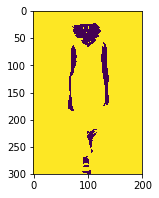

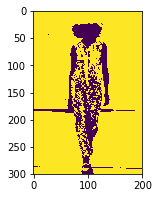

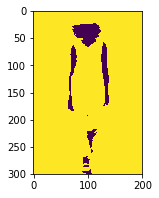

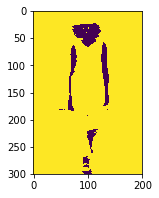

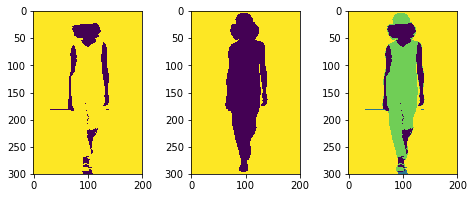

accuracy: 0.830233333333
precision: 0.962415130941
recall: 0.2835
harmonic mean: 0.437982785257


(0.8302333333333334, 0.9624151309408342, 0.2835, 0.4379827852571176)

In [27]:
from_paths_to_conf_dict(test_img, seg_img, 0.3, 16)


for threshold 0.1


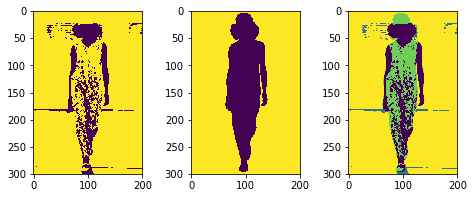

accuracy: 0.870916666667
precision: 0.876671082741
recall: 0.519928571429
harmonic mean: 0.652737299915

for threshold 0.3


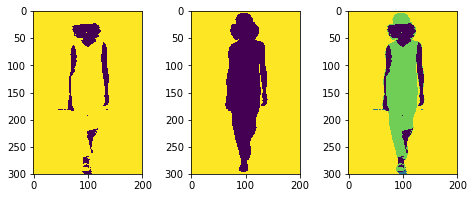

accuracy: 0.828966666667
precision: 0.970306995471
recall: 0.275428571429
harmonic mean: 0.42906420385

for threshold 0.5


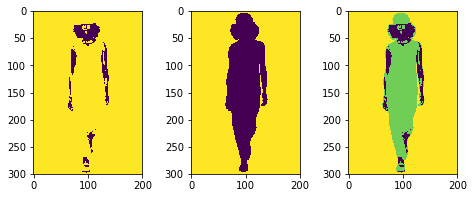

accuracy: 0.8144
precision: 0.993452791178
recall: 0.205928571429
harmonic mean: 0.341143059993

for threshold 0.7


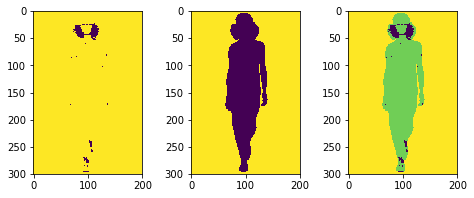

accuracy: 0.781016666667
precision: 0.997687861272
recall: 0.0616428571429
harmonic mean: 0.116111671712

for threshold 0.9


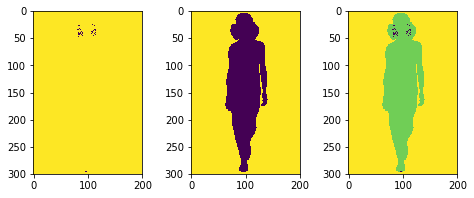

accuracy: 0.7686
precision: 1.0
recall: 0.00828571428571
harmonic mean: 0.0164352507793


In [28]:
dicts_by_threshold = {}

for t in [0.1, 0.3, 0.5, 0.7, 0.9]:
    print '\nfor threshold {}'.format(t)
    acc, prec, rec, harm = from_paths_to_conf_dict(test_img, \
                        seg_img, t, 16)
    dicts_by_threshold[t] = {'accuracy': acc, 'precision': prec, 'recall': rec}
    
    
    


for threshold 0.05


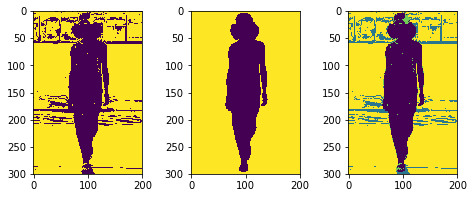

accuracy: 0.898766666667
precision: 0.708644835211
recall: 0.961428571429
harmonic mean: 0.815905922289

for threshold 0.1


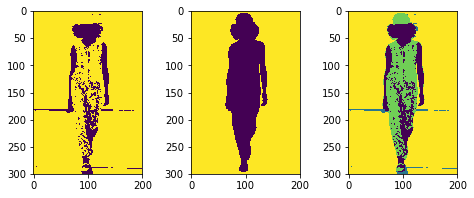

accuracy: 0.86185
precision: 0.908921666905
recall: 0.453357142857
harmonic mean: 0.604965924796

for threshold 0.15


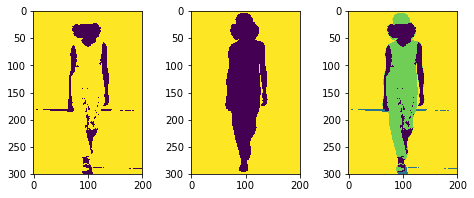

accuracy: 0.832566666667
precision: 0.912734864301
recall: 0.312285714286
harmonic mean: 0.465353911655


In [30]:
dicts_by_threshold = {}

for t in [0.05, 0.1, 0.15]:
    print '\nfor threshold {}'.format(t)
    acc, prec, rec, harm = from_paths_to_conf_dict(test_img, \
                        seg_img, t, 16)
    dicts_by_threshold[t] = {'accuracy': acc, 'precision': prec, 'recall': rec}
    
    
    


for num bg points 4


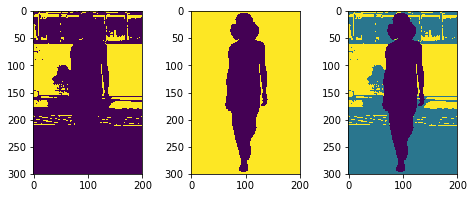

accuracy: 0.487466666667
precision: 0.312508394144
recall: 0.997214285714
harmonic mean: 0.475883696356

for num bg points 8


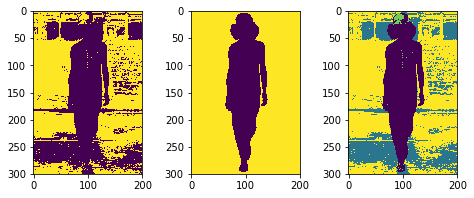

accuracy: 0.7523
precision: 0.484567459181
recall: 0.966642857143
harmonic mean: 0.645535203205

for num bg points 16


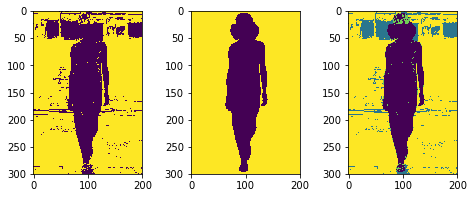

accuracy: 0.9032
precision: 0.720262422026
recall: 0.956714285714
harmonic mean: 0.821818628053

for num bg points 32


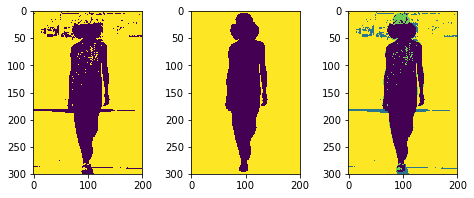

accuracy: 0.9512
precision: 0.874458874459
recall: 0.923428571429
harmonic mean: 0.898276820456


In [32]:
dicts_by_bg_pts = {}

for n in [4, 8, 16, 32]:
    print '\nfor num bg points {}'.format(n)
    acc, prec, rec, harm = from_paths_to_conf_dict(test_img, \
                        seg_img, 0.05, n)
    dicts_by_bg_pts[n] = {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': harm}
    
    

In [33]:
def search_for_best_thresh(test_img, seg_img, thresh_list):
    maxf1 = 0
    best_t = 0
    for t in thresh_list:
        acc, prec, rec, harm = from_paths_to_conf_dict(test_img, seg_img, t, 16)
        if harm > maxf1:
            maxf1 = harm
            best_t = t
    return best_t
        
    

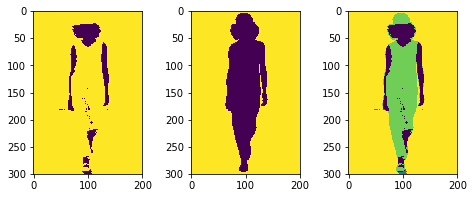

accuracy: 0.82995
precision: 0.973323360758
recall: 0.278857142857
harmonic mean: 0.433512853256


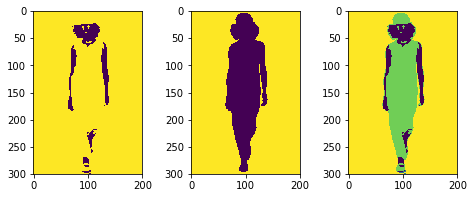

accuracy: 0.822983333333
precision: 0.9881537128
recall: 0.244285714286
harmonic mean: 0.391730141458


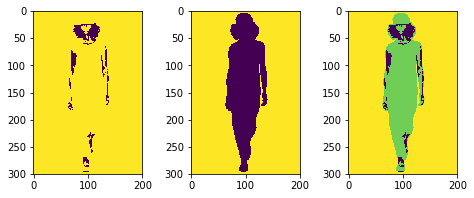

accuracy: 0.802116666667
precision: 0.995342338146
recall: 0.152642857143
harmonic mean: 0.264693131851


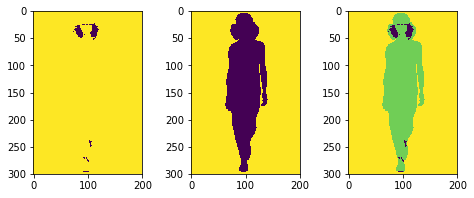

accuracy: 0.777466666667
precision: 0.998461538462
recall: 0.0463571428571
harmonic mean: 0.0886006825939


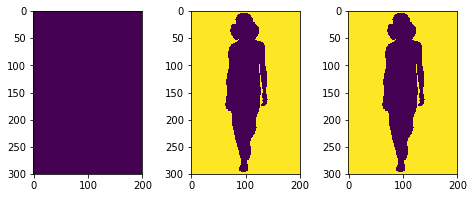

accuracy: 0.766683333333
precision: 1.0
recall: 7.14285714286e-05
harmonic mean: 0.000142846939504


In [34]:
best_t = search_for_best_thresh(test_img, seg_img, [0.2, 0.4, 0.6, 0.8, 1.0])

In [35]:
def make_thresh_list(thresh, iteration):
    min_t = thresh - thresh*(1./iteration)
       
    max_t = thresh + thresh*(1./iteration)
    print "min and max ", min_t, max_t
    return np.linspace(min_t, max_t, 5)


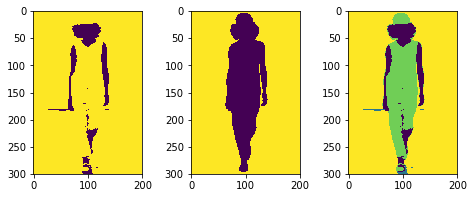

accuracy: 0.830983333333
precision: 0.948616600791
recall: 0.291428571429
harmonic mean: 0.445877274466


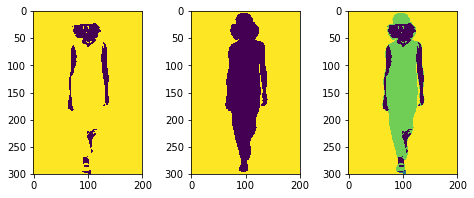

accuracy: 0.825016666667
precision: 0.984768762116
recall: 0.254
harmonic mean: 0.403838510022


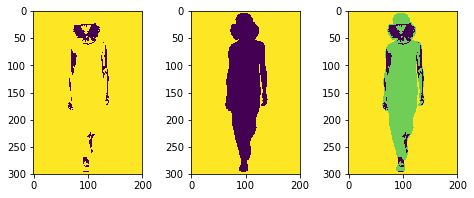

accuracy: 0.80445
precision: 0.995627459554
recall: 0.162642857143
harmonic mean: 0.279609504513


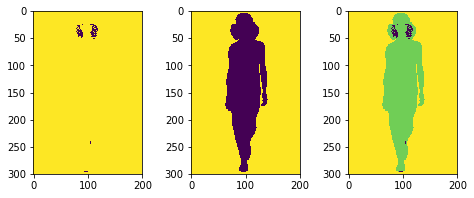

accuracy: 0.773366666667
precision: 1.0
recall: 0.0287142857143
harmonic mean: 0.0558255797806


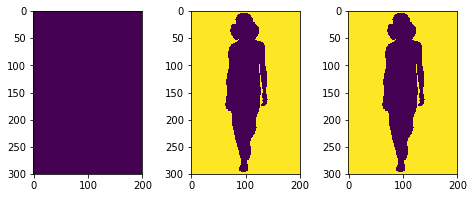

accuracy: 0.766683333333
precision: 1.0
recall: 7.14285714286e-05
harmonic mean: 0.000142846939504
best threshold so far  0.2
min and max  0.1 0.3
what I will search on next  [ 0.1   0.15  0.2   0.25  0.3 ]


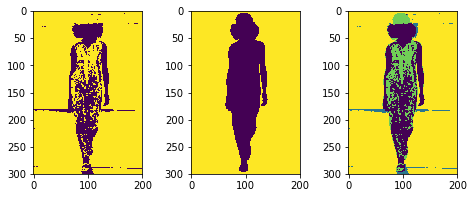

accuracy: 0.903183333333
precision: 0.913394569496
recall: 0.646357142857
harmonic mean: 0.75701677333


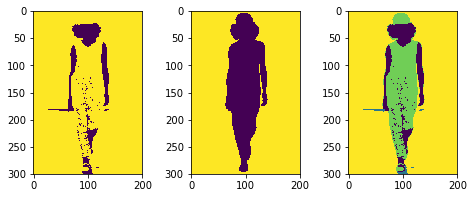

accuracy: 0.837283333333
precision: 0.949692209722
recall: 0.319571428571
harmonic mean: 0.47822136711


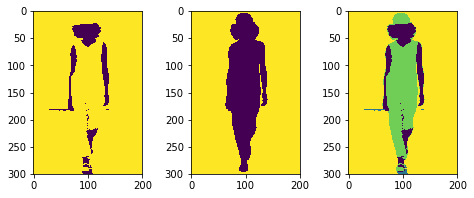

accuracy: 0.830483333333
precision: 0.953565505804
recall: 0.2875
harmonic mean: 0.441797925471


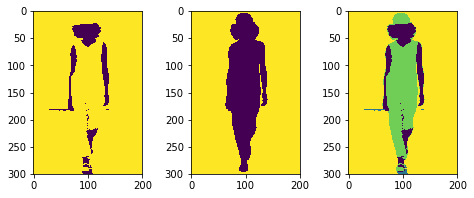

accuracy: 0.830483333333
precision: 0.953565505804
recall: 0.2875
harmonic mean: 0.441797925471


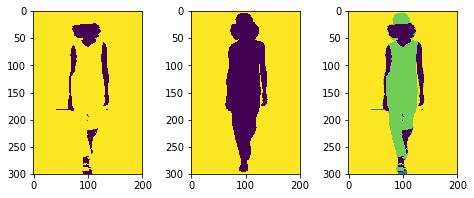

accuracy: 0.829616666667
precision: 0.966641957005
recall: 0.279428571429
harmonic mean: 0.4335346595
best threshold so far  0.1
min and max  0.0666666666667 0.133333333333
what I will search on next  [ 0.06666667  0.08333333  0.1         0.11666667  0.13333333]


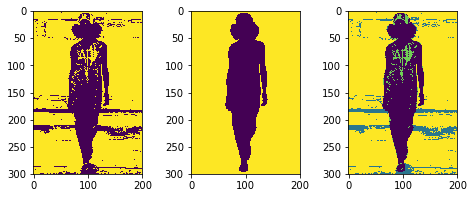

accuracy: 0.901283333333
precision: 0.738752586462
recall: 0.892571428571
harmonic mean: 0.808410156882


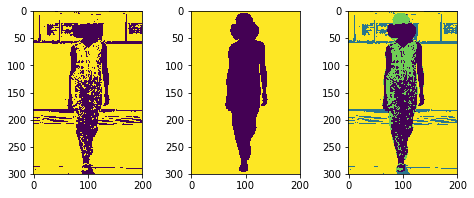

accuracy: 0.84485
precision: 0.671693141058
recall: 0.655428571429
harmonic mean: 0.663461190846


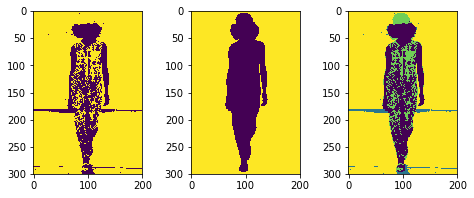

accuracy: 0.912533333333
precision: 0.909584425309
recall: 0.694142857143
harmonic mean: 0.787392643008


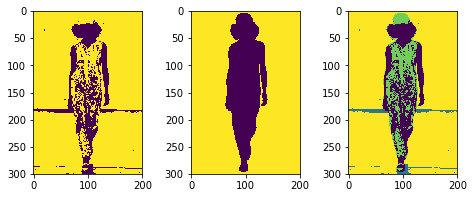

accuracy: 0.885283333333
precision: 0.876760190577
recall: 0.5915
harmonic mean: 0.706419279164


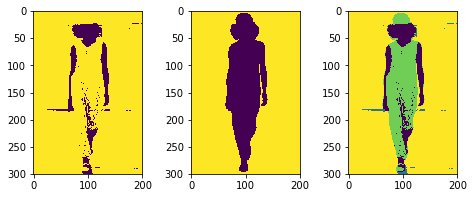

accuracy: 0.8368
precision: 0.918290258449
recall: 0.329928571429
harmonic mean: 0.485444035733
best threshold so far  0.0666666666667
min and max  0.05 0.0833333333333
what I will search on next  [ 0.05        0.05833333  0.06666667  0.075       0.08333333]


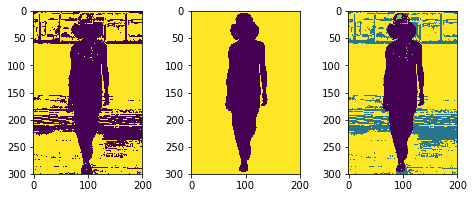

accuracy: 0.805516666667
precision: 0.546858038837
recall: 0.971571428571
harmonic mean: 0.699817353947


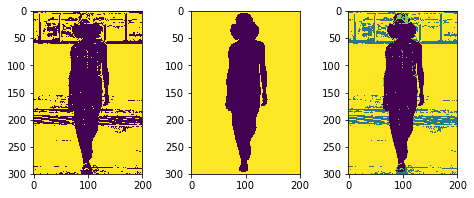

accuracy: 0.8649
precision: 0.643099932019
recall: 0.946
harmonic mean: 0.765681910158


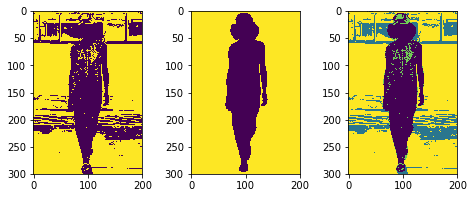

accuracy: 0.828
precision: 0.583995252442
recall: 0.913785714286
harmonic mean: 0.712582855233


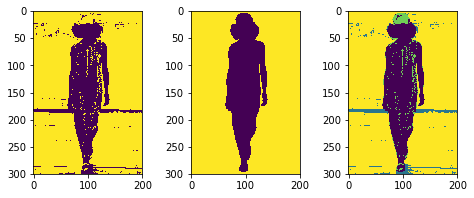

accuracy: 0.94135
precision: 0.867058905933
recall: 0.884214285714
harmonic mean: 0.875552569226


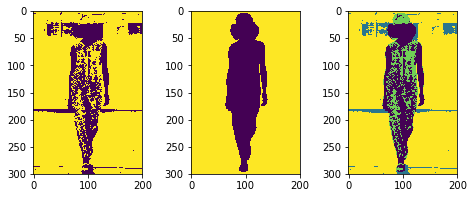

accuracy: 0.880683333333
precision: 0.780070416769
recall: 0.6805
harmonic mean: 0.726891237172


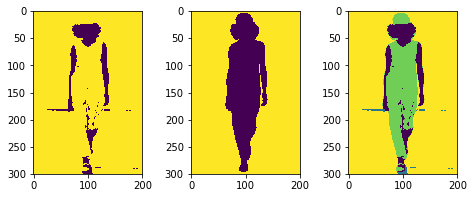

accuracy: 0.83235
precision: 0.928649118991
recall: 0.304928571429
harmonic mean: 0.459106307469


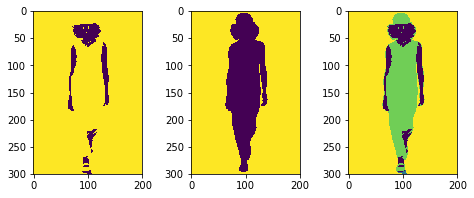

accuracy: 0.826933333333
precision: 0.98085106383
recall: 0.263428571429
harmonic mean: 0.415315315315


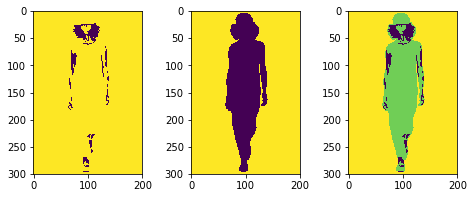

accuracy: 0.799533333333
precision: 0.994979919679
recall: 0.141571428571
harmonic mean: 0.247873936968


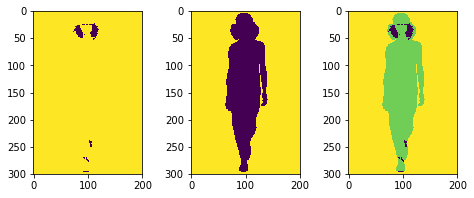

accuracy: 0.77775
precision: 0.998500749625
recall: 0.0475714285714
harmonic mean: 0.0908161178155


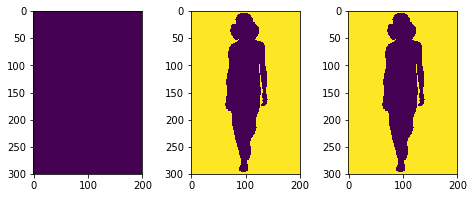

accuracy: 0.766683333333
precision: 1.0
recall: 7.14285714286e-05
harmonic mean: 0.000142846939504
best threshold so far  0.2
min and max  0.1 0.3
what I will search on next  [ 0.1   0.15  0.2   0.25  0.3 ]


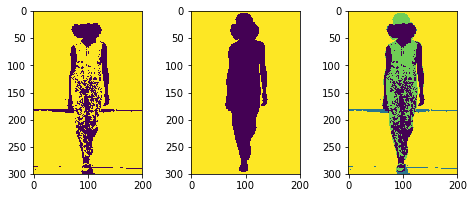

accuracy: 0.8795
precision: 0.902019002375
recall: 0.5425
harmonic mean: 0.677520071365


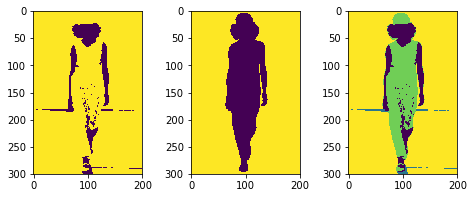

accuracy: 0.8335
precision: 0.905050505051
recall: 0.32
harmonic mean: 0.472823218997


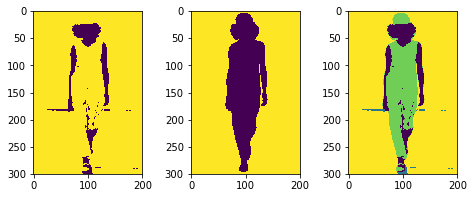

accuracy: 0.832483333333
precision: 0.930268032251
recall: 0.304928571429
harmonic mean: 0.459303889397


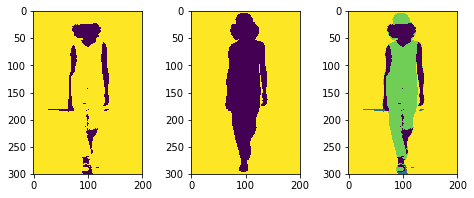

accuracy: 0.830933333333
precision: 0.946089773253
recall: 0.292071428571
harmonic mean: 0.446348651894


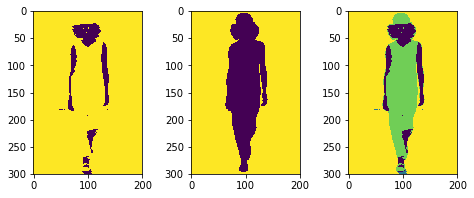

accuracy: 0.828666666667
precision: 0.973282442748
recall: 0.273214285714
harmonic mean: 0.42665923034
best threshold so far  0.1
min and max  0.0666666666667 0.133333333333
what I will search on next  [ 0.06666667  0.08333333  0.1         0.11666667  0.13333333]


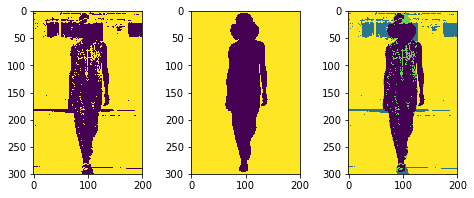

accuracy: 0.911683333333
precision: 0.771821305842
recall: 0.882357142857
harmonic mean: 0.82339610065


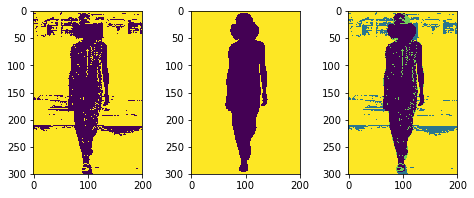

accuracy: 0.912033333333
precision: 0.759676074789
recall: 0.911285714286
harmonic mean: 0.828602974605


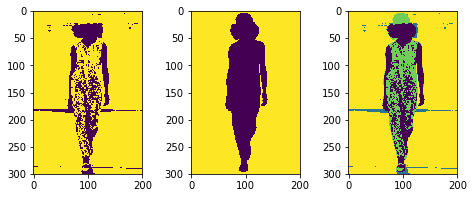

accuracy: 0.881133333333
precision: 0.886798828565
recall: 0.562357142857
harmonic mean: 0.68825946324


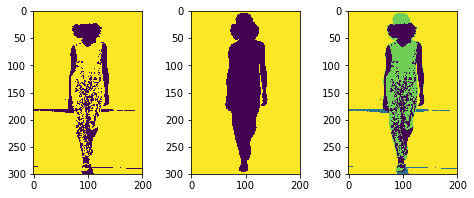

accuracy: 0.865866666667
precision: 0.899141630901
recall: 0.478857142857
harmonic mean: 0.624906785981


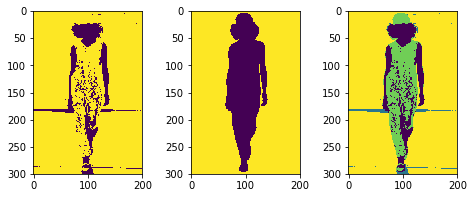

accuracy: 0.85045
precision: 0.870996309963
recall: 0.4215
harmonic mean: 0.568086642599
best threshold so far  0.0833333333333
min and max  0.0625 0.104166666667
what I will search on next  [ 0.0625      0.07291667  0.08333333  0.09375     0.10416667]


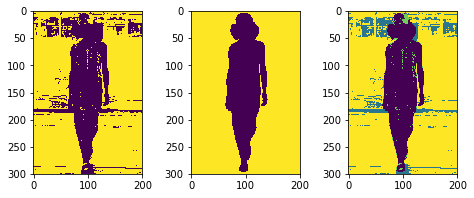

accuracy: 0.90235
precision: 0.721886072499
recall: 0.945928571429
harmonic mean: 0.818859174525


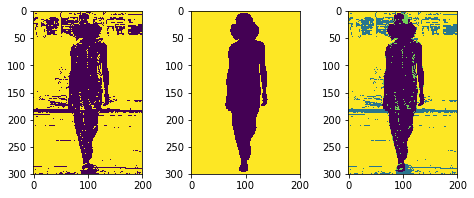

accuracy: 0.893416666667
precision: 0.708253464045
recall: 0.923714285714
harmonic mean: 0.801760748938


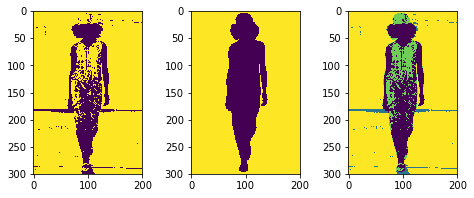

accuracy: 0.911633333333
precision: 0.896806569343
recall: 0.702071428571
harmonic mean: 0.787580128205


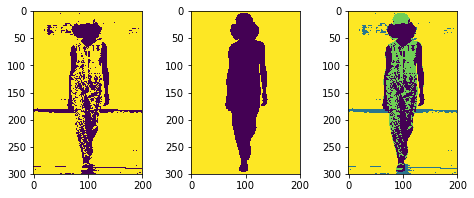

accuracy: 0.87995
precision: 0.835786977571
recall: 0.604214285714
harmonic mean: 0.701380539779


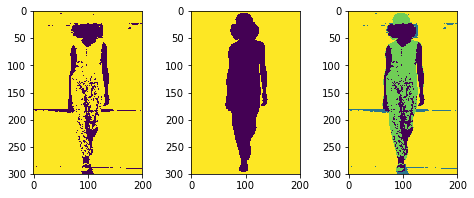

accuracy: 0.848616666667
precision: 0.859903381643
recall: 0.419571428571
harmonic mean: 0.563967164322


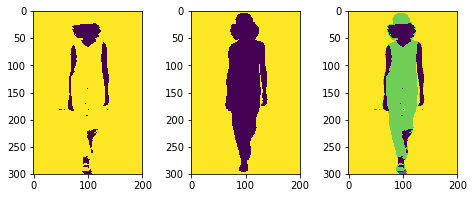

accuracy: 0.82895
precision: 0.9745999492
recall: 0.274071428571
harmonic mean: 0.427830740927


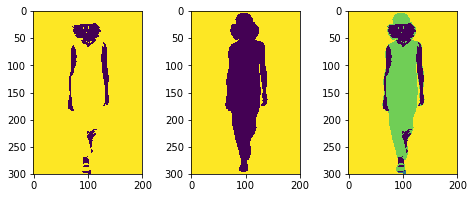

accuracy: 0.825933333333
precision: 0.983941208492
recall: 0.258214285714
harmonic mean: 0.409075478103


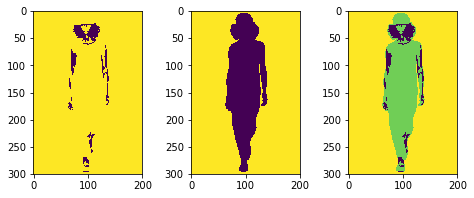

accuracy: 0.80335
precision: 0.995497523638
recall: 0.157928571429
harmonic mean: 0.272609580174


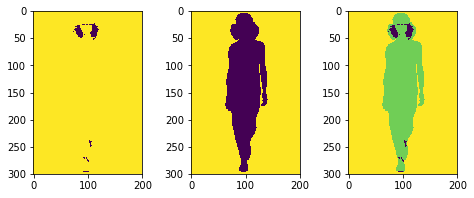

accuracy: 0.777466666667
precision: 0.998461538462
recall: 0.0463571428571
harmonic mean: 0.0886006825939


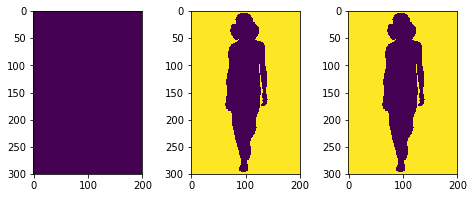

accuracy: 0.766683333333
precision: 1.0
recall: 7.14285714286e-05
harmonic mean: 0.000142846939504
best threshold so far  0.2
min and max  0.1 0.3
what I will search on next  [ 0.1   0.15  0.2   0.25  0.3 ]


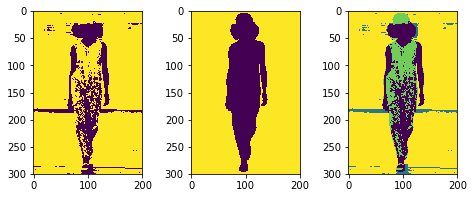

accuracy: 0.87705
precision: 0.835138143913
recall: 0.589428571429
harmonic mean: 0.6910933378


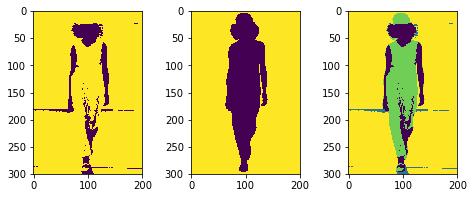

accuracy: 0.834883333333
precision: 0.871348212666
recall: 0.343
harmonic mean: 0.492235149403


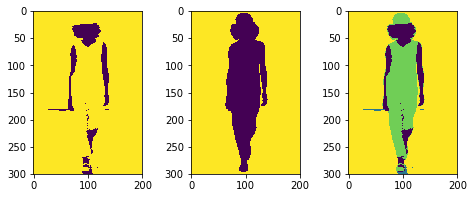

accuracy: 0.829866666667
precision: 0.949289099526
recall: 0.286142857143
harmonic mean: 0.439736553238


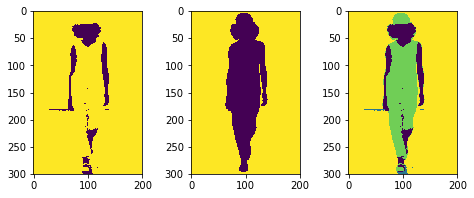

accuracy: 0.83105
precision: 0.950548168883
recall: 0.291071428571
harmonic mean: 0.445671788702


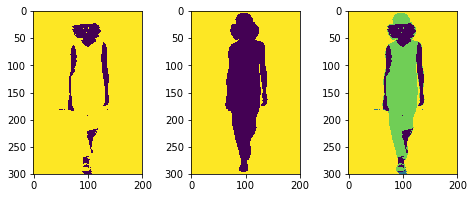

accuracy: 0.8288
precision: 0.972137791287
recall: 0.274142857143
harmonic mean: 0.427679964341
best threshold so far  0.1
min and max  0.0666666666667 0.133333333333
what I will search on next  [ 0.06666667  0.08333333  0.1         0.11666667  0.13333333]


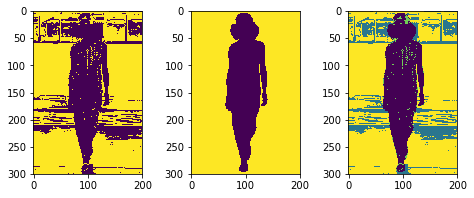

accuracy: 0.831466666667
precision: 0.586323268206
recall: 0.943142857143
harmonic mean: 0.723110624315


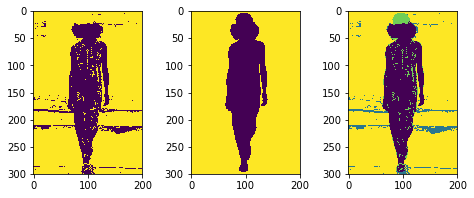

accuracy: 0.934433333333
precision: 0.844584417363
recall: 0.881142857143
harmonic mean: 0.862476403552


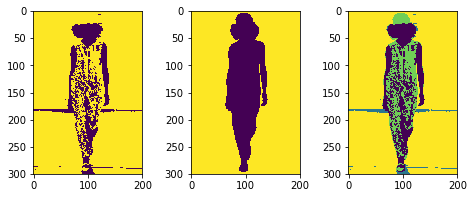

accuracy: 0.8848
precision: 0.898112783644
recall: 0.571071428571
harmonic mean: 0.698192297616


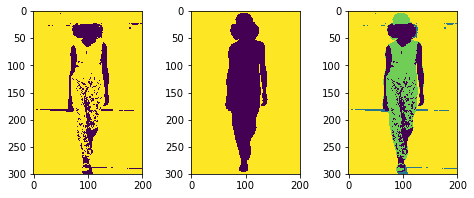

accuracy: 0.849216666667
precision: 0.889938592348
recall: 0.403714285714
harmonic mean: 0.555451820549


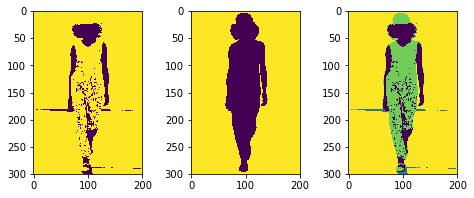

accuracy: 0.846116666667
precision: 0.923131546245
recall: 0.371428571429
harmonic mean: 0.529720368767
best threshold so far  0.0833333333333
min and max  0.0625 0.104166666667
what I will search on next  [ 0.0625      0.07291667  0.08333333  0.09375     0.10416667]


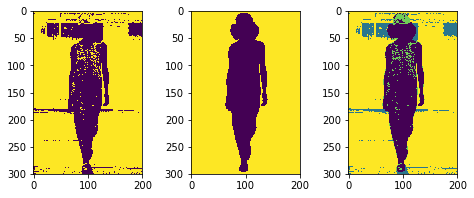

accuracy: 0.917283333333
precision: 0.781824985966
recall: 0.895357142857
harmonic mean: 0.834748443379


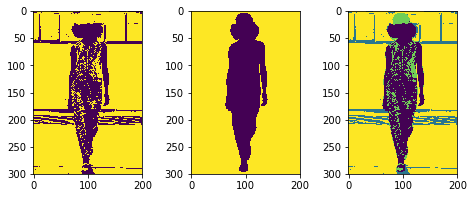

accuracy: 0.874883333333
precision: 0.709627429457
recall: 0.785
harmonic mean: 0.74541323295


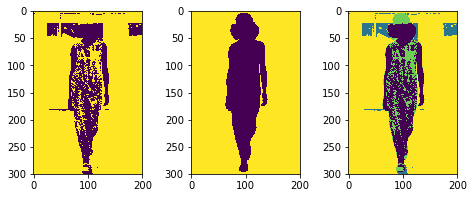

accuracy: 0.898866666667
precision: 0.826419753086
recall: 0.717214285714
harmonic mean: 0.767954110899


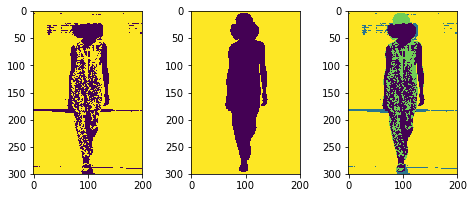

accuracy: 0.8961
precision: 0.873652809854
recall: 0.6485
harmonic mean: 0.744424401443


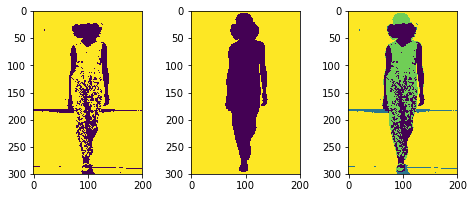

accuracy: 0.868883333333
precision: 0.883168811696
recall: 0.504857142857
harmonic mean: 0.642457846657


In [36]:


list_of_bests = []
for i in range(3):
    best_t = search_for_best_thresh(test_img, seg_img, [0.2, 0.4, 0.6, 0.8, 1.0])
    for j in range(2,5):
        print "best threshold so far ", best_t
        next_t = make_thresh_list(best_t, j)
        print "what I will search on next ", next_t
        best_t = search_for_best_thresh(test_img, seg_img, next_t)
    list_of_bests.append(best_t)
    
    

In [37]:
list_of_bests

[0.075000000000000011, 0.0625, 0.0625]

Face stuff!

In [5]:
cm.face_color_list

[[0.62690799396681784, 0.43294117647058777, 0.31318250377073897],
 [0.73743589743589766, 0.57357466063348461, 0.45110105580693743],
 [0.76675716440422315, 0.76199095022624441, 0.73743589743589744],
 [0.68404223227752636, 0.4788536953242839, 0.49936651583710479],
 [0.62214177978883867, 0.40331825037707347, 0.42268476621417789],
 [0.49351432880844626, 0.31589743589743585, 0.21840120663650048],
 [0.78666666666666663, 0.78039215686274488, 0.75855203619909517],
 [0.38684766214177946, 0.23933634992458513, 0.13466063348416296]]

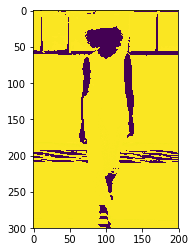

In [8]:
plt.imshow(cm.face_composite_mask)
plt.show()

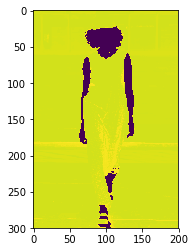

In [9]:
plt.imshow(cm.full_composite_mask)
plt.show()

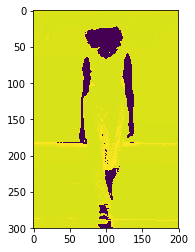

In [12]:
plt.imshow(cm.bg_composite_mask)
plt.show()

In [14]:
cm.plot_many_masks_face()

NameError: global name 'num_face_colors' is not defined

In [202]:
dicts_by_bg_pts

{4: {'accuracy': 0.7489,
  'precision': 0.5049906306168496,
  'recall': 0.8615515104064723},
 8: {'accuracy': 0.8462666666666666,
  'precision': 0.6606475388260068,
  'recall': 0.818751223331376},
 16: {'accuracy': 0.8991166666666667,
  'precision': 0.8212553692670085,
  'recall': 0.7734064069941933},
 32: {'accuracy': 0.9022833333333333,
  'precision': 0.832536893886156,
  'recall': 0.7729496966138187}}

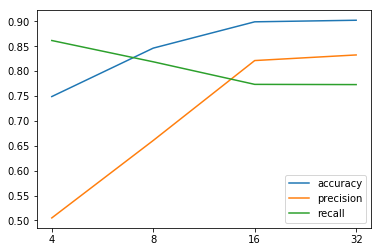

In [232]:
plt.plot([d['accuracy'] for d in sorted(dicts_by_bg_pts.values())], label='accuracy')
plt.plot([d['precision'] for d in sorted(dicts_by_bg_pts.values())], label='precision')
plt.plot([d['recall'] for d in sorted(dicts_by_bg_pts.values())], label='recall')

plt.xticks(range(len(dicts_by_bg_pts.keys())), sorted(dicts_by_bg_pts.keys()))


plt.legend()
plt.show()

In [201]:
dicts_by_threshold

{0.1: {'accuracy': 0.7381,
  'precision': 0.49322027959777165,
  'recall': 0.9184445749331246},
 0.3: {'accuracy': 0.7909166666666667,
  'precision': 0.5611052539096819,
  'recall': 0.8333659555033601},
 0.5: {'accuracy': 0.8958,
  'precision': 0.7996038296467481,
  'recall': 0.7901089580478894},
 0.7: {'accuracy': 0.91625,
  'precision': 0.9095245667037685,
  'recall': 0.7463952502120441},
 0.9: {'accuracy': 0.90785,
  'precision': 0.8508809626128062,
  'recall': 0.7751027598355843}}

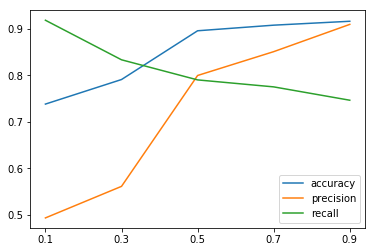

In [234]:
plt.plot([d['accuracy'] for d in sorted(dicts_by_threshold.values())], label='accuracy')
plt.plot([d['precision'] for d in sorted(dicts_by_threshold.values())], label='precision')
plt.plot([d['recall'] for d in sorted(dicts_by_threshold.values())], label='recall')

plt.xticks(range(len(dicts_by_threshold.keys())), sorted(dicts_by_threshold.keys()))


plt.legend()
plt.show()

for threshhold 0.5

for num points 8


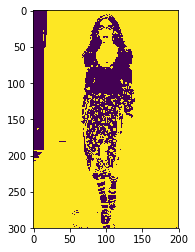

accuracy: 0.200966666667
precision: 1.0
recall: 0.200966666667
for num points 12


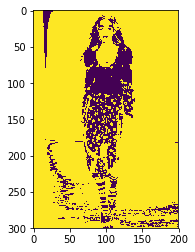

accuracy: 0.171166666667
precision: 1.0
recall: 0.171166666667
for num points 16


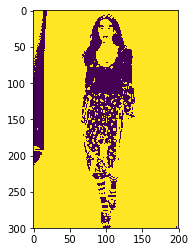

accuracy: 0.182833333333
precision: 1.0
recall: 0.182833333333
for num points 20


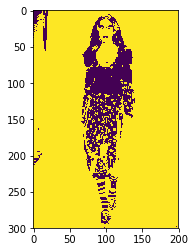

accuracy: 0.147116666667
precision: 1.0
recall: 0.147116666667
for threshhold 0.7

for num points 8


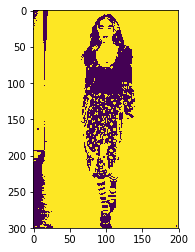

accuracy: 0.180516666667
precision: 1.0
recall: 0.180516666667
for num points 12


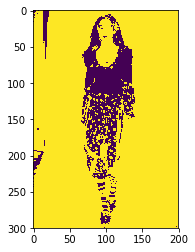

accuracy: 0.147483333333
precision: 1.0
recall: 0.147483333333
for num points 16


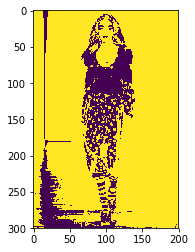

accuracy: 0.19545
precision: 1.0
recall: 0.19545
for num points 20


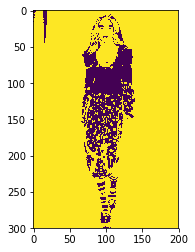

accuracy: 0.138
precision: 1.0
recall: 0.138
for threshhold 0.9

for num points 8


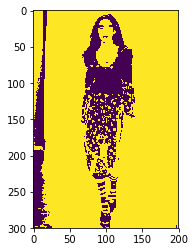

accuracy: 0.19585
precision: 1.0
recall: 0.19585
for num points 12


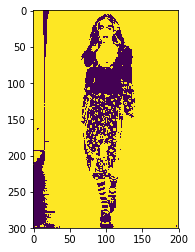

accuracy: 0.182516666667
precision: 1.0
recall: 0.182516666667
for num points 16


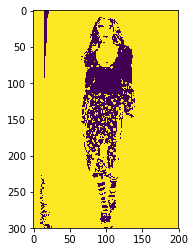

accuracy: 0.142
precision: 1.0
recall: 0.142
for num points 20


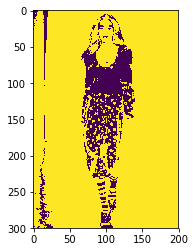

accuracy: 0.148366666667
precision: 1.0
recall: 0.148366666667


In [60]:
dicts_by_thresh_grid = {}
for t in [0.5, 0.7, 0.9]:
    dicts_by_thresh_grid[t] = {} 
    print 'for threshhold {}\n'.format(t)
    for n in [8, 12, 16, 20]:
        print 'for num points {}'.format(n)
        acc, prec, rec = from_paths_to_conf_dict(test_img, \
                        seg_img, 0.4, n)
        dicts_by_thresh_grid[t][n] = {'accuracy': acc, 'precision': prec, 'recall': rec}
        

In [241]:
dicts_by_thresh_grid

{0.3: {8: {'accuracy': 0.8870666666666667,
   'precision': 0.7704472136124992,
   'recall': 0.7946760618516344},
  12: {'accuracy': 0.8718,
   'precision': 0.7230499561787905,
   'recall': 0.8073987081620669},
  16: {'accuracy': 0.8704333333333333,
   'precision': 0.7203711268016573,
   'recall': 0.8054413779604619}},
 0.5: {8: {'accuracy': 0.8781666666666667,
   'precision': 0.744286671948321,
   'recall': 0.7968291250733999},
  12: {'accuracy': 0.8751833333333333,
   'precision': 0.7438705662725575,
   'recall': 0.7799308409995432},
  16: {'accuracy': 0.90545,
   'precision': 0.8557635613207547,
   'recall': 0.7575520323611926}},
 0.7: {8: {'accuracy': 0.8950666666666667,
   'precision': 0.8040126573756143,
   'recall': 0.7791479089189013},
  12: {'accuracy': 0.8825,
   'precision': 0.7721444071809035,
   'recall': 0.7660990409082012},
  16: {'accuracy': 0.8910833333333333,
   'precision': 0.7939288579834181,
   'recall': 0.7747112937952633}}}

In [111]:
accuracy = (confusion_dict['true_bg_pred_bg'] + confusion_dict['true_fig_pred_fig']) / 60000.0
accuracy

0.91815

In [114]:
precision_of_fig = (confusion_dict['true_fig_pred_fig'])*1. / \
            (confusion_dict['true_bg_pred_fig'] + confusion_dict['true_fig_pred_fig'])
precision_of_fig

0.9884637028700056

In [116]:
recall_of_fig = (confusion_dict['true_fig_pred_fig'])*1. / \
        (confusion_dict['true_fig_pred_bg'] + confusion_dict['true_fig_pred_fig'])
recall_of_fig

0.6876100998238402

In [4]:
def get_background_one_image(filepath, num_points = 16):
    background_colors = []
    im = plt.imread(filepath)
    im = np.array(im, dtype=np.float64) / 255

    h, w, colors = im.shape

    for i in range(int(num_points/2)):
        row = np.random.choice(h)
        col = np.random.choice(xrange(int(w/8)))
        color_block = im[int(row-4):int(row+4), int(col-4):int(col+4)]
        ave_color = [avg_each_color(color_block, color) for color in ['r', 'g', 'b']]
        background_colors.append(ave_color)
    for i in range(int(num_points/2)):
        row = np.random.choice(h)
        col = np.random.choice(xrange(int((7*w/8)), w))
        color_block = im[int(row-4):int(row+4), int(col-4):int(col+4)]
        ave_color = [avg_each_color(color_block, color) for color in ['r', 'g', 'b']]
        background_colors.append(ave_color)

    return background_colors

def avg_each_color(color_block, color):
    color_dict = {'r':0, 'g':1, 'b':2}
    index = color_dict[color]
    all_colors = [color[index] for row in color_block for color in row]
    ave_color = sum(all_colors)/(len(all_colors) + 1)
    return ave_color

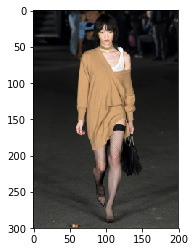

In [5]:
cm = CompositeMask('data/Alexander-Wang-spring-2018-look077.jpg', 1, 16)
cm.show_orig_image()



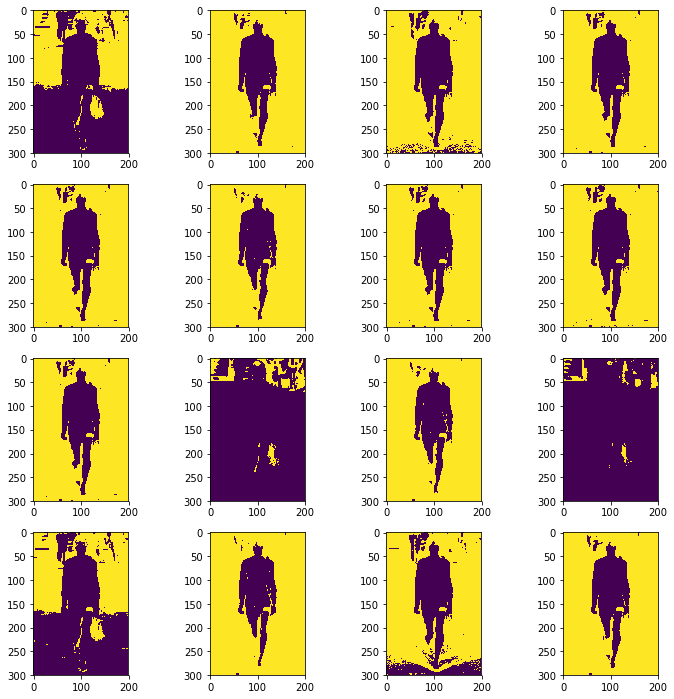

In [6]:
cm.plot_many_masks()

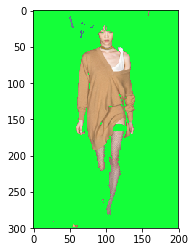

In [7]:
cm.show_masked_image()

In [8]:
#going to play with contours

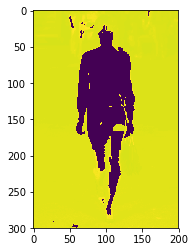

In [9]:
plt.imshow(cm.composite_mask)
plt.show()

In [22]:
lower = 0
upper = 15
shapeMask = cv2.inRange(cm.composite_mask, lower, upper)

contoured_img, contours, hierarchy = \
                    cv2.findContours(shapeMask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    

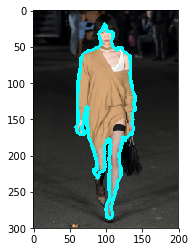

In [29]:
for c in contours:
    #looking for contours that are at least 10% the size of the total image. This needs to be explored further.
    if cv2.contourArea(c) > .1*cm.image.shape[0]*cm.image.shape[1]:
        cv2.drawContours(cm.image, [c], 0, (255, 255, 0), 3)    
        plt.imshow(bgr_to_rgb(cm.image.copy()))
        plt.show()
        
    

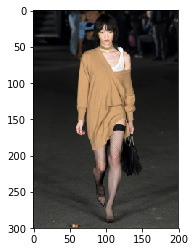

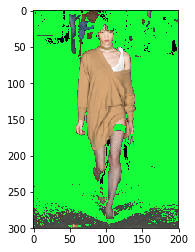

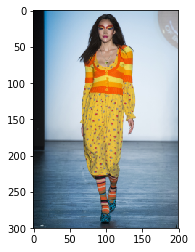

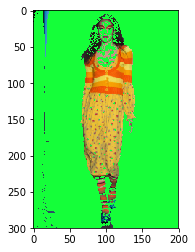

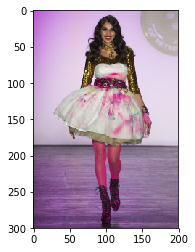

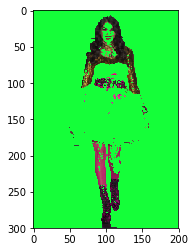

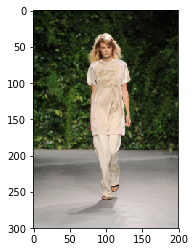

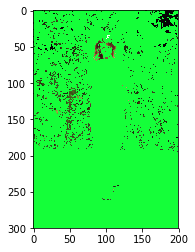

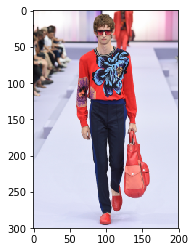

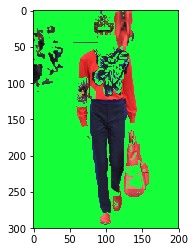

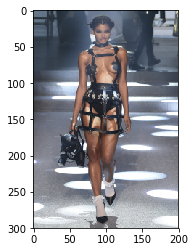

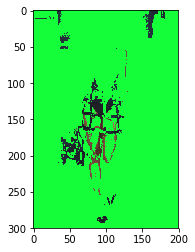

In [30]:
for im in os.listdir('data/'):
    if im.endswith('jpg'):
        cm = CompositeMask('data/' + im)
        cm.show_orig_image()
        cm.show_masked_image()

#todo: turn output into grid

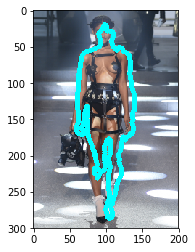

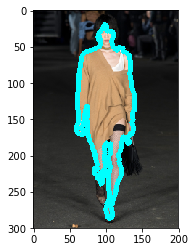

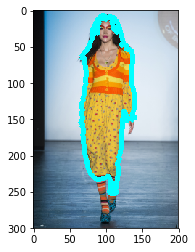

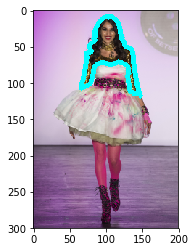

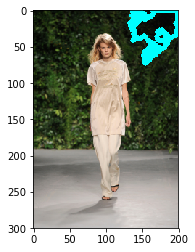

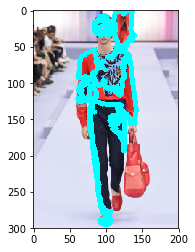

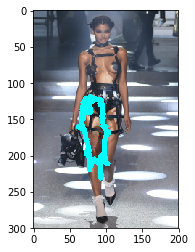

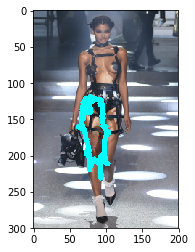

In [31]:
lower = 0
upper = 15

for im in os.listdir('data/'):
    if im.endswith('jpg'):
        cm = CompositeMask('data/' + im)
        shapeMask = cv2.inRange(cm.composite_mask, lower, upper)
        contoured_img, contours, hierarchy = \
                    cv2.findContours(shapeMask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # loop over the contours
    largest_contour = max(cv2.contourArea(cnt) for cnt in contours)
    for c in contours:
        # draw the contour and show it
        if cv2.contourArea(c) == largest_contour:
            cv2.drawContours(cm.image, [c], 0, (255, 255, 0), 5)    
            plt.imshow(bgr_to_rgb(cm.image.copy()))

        plt.show()


        

In [14]:
#thoughts: separate top from bottom
#explore more about the findContours arguments
#make some ground truth images

In [15]:
#now let's look at various different thresholds

In [32]:
def plot_mask_and_contour(path, threshold):
    fig, axs = plt.subplots(1,3)
    cmx = CompositeMask(path, threshold=threshold)
    axs[0].imshow(bgr_to_rgb(cmx.image))
    axs[1].imshow(cmx.masked_image)
    contour_plot(cmx, axs[2])
    plt.tight_layout()
    plt.show()
    
    
def contour_plot(cm_object, ax, lower=0, upper=15):
    shapeMask = cv2.inRange(cm_object.composite_mask, lower, upper)
    contoured_img, contours, hierarchy = \
                    cv2.findContours(shapeMask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # loop over the contours
    areas = [cv2.contourArea(cnt) for cnt in contours]
    if len(areas) > 0:
        largest_contour = max(cv2.contourArea(cnt) for cnt in contours)
        for c in contours:
            # draw the contour and show it
            if cv2.contourArea(c) == largest_contour:
                cv2.drawContours(cm_object.image, [c], 0, (255, 255, 0), 5)    
                ax.imshow(bgr_to_rgb(cm_object.image.copy()))


    
    

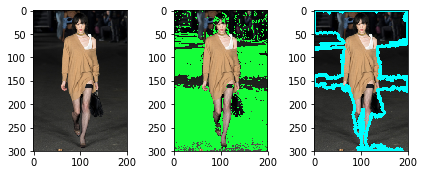

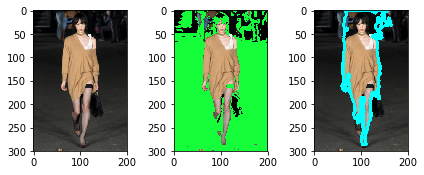

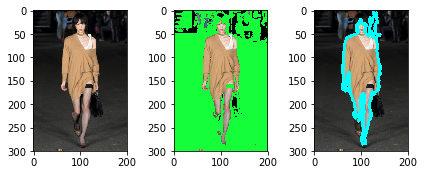

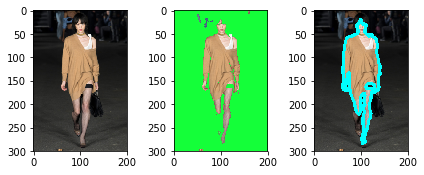

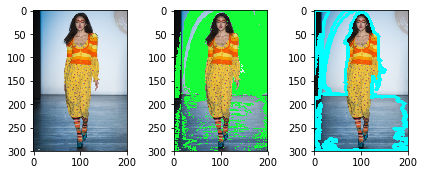

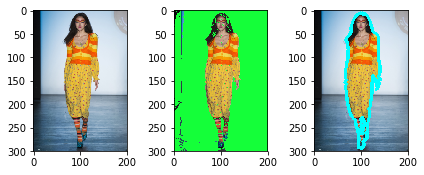

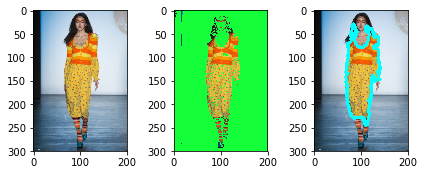

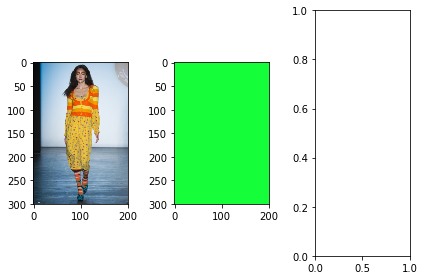

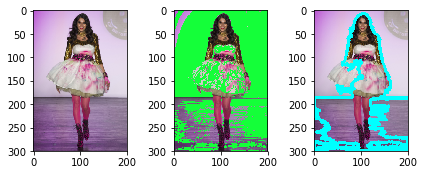

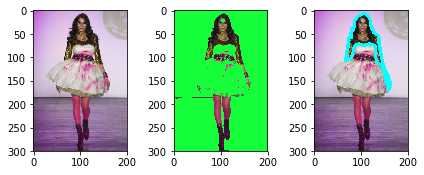

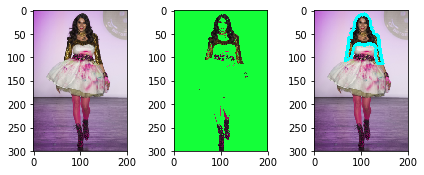

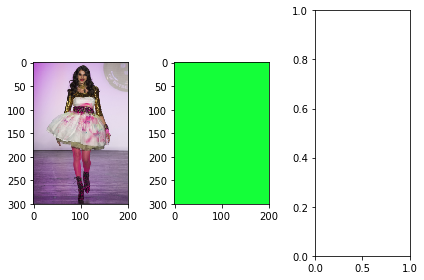

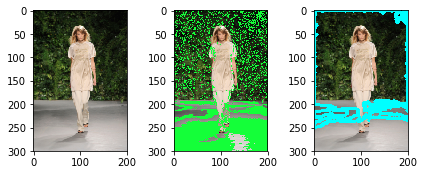

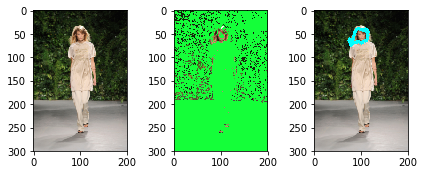

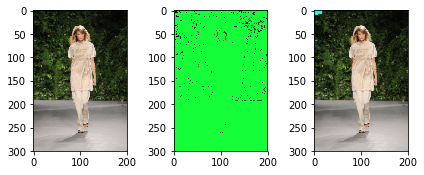

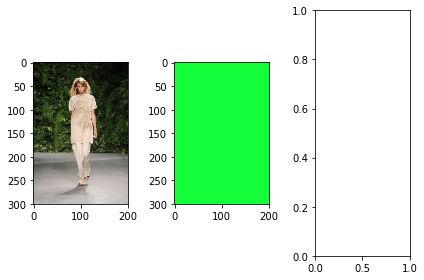

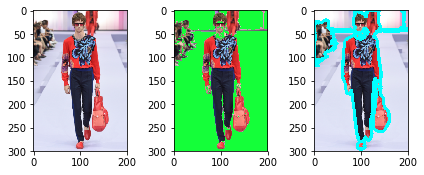

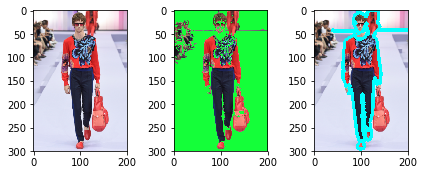

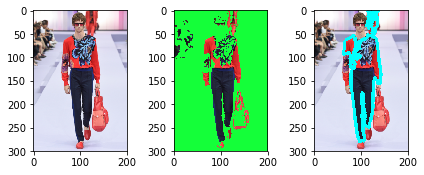

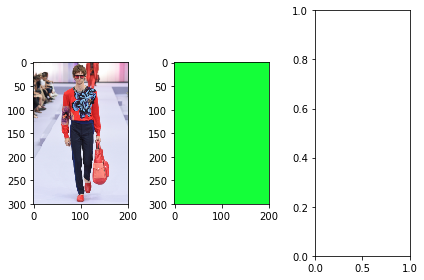

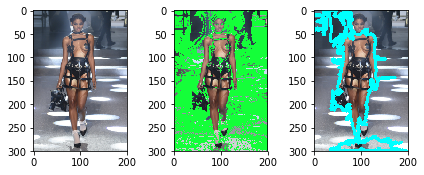

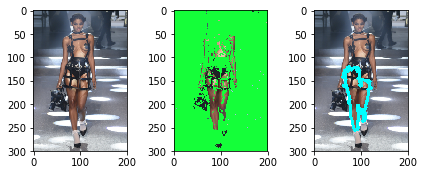

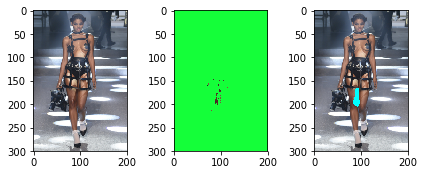

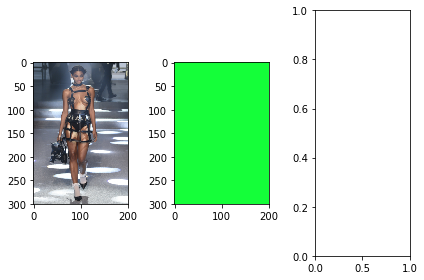

In [33]:
thresh = [0.1, 0.3, 0.5, 1.0]
for im in os.listdir('data/'):
    if im.endswith('jpg'):
        for t in thresh:
            plot_mask_and_contour('data/' + im, t)

            


In [ ]:
#figure out how to fill in everything that is outside the contour

In [35]:
def get_std_devs(image):
    color_indicators = ['b', 'g', 'r']
    std_devs = {}
    
    for color, ci in zip(cv2.split(image), color_indicators):
        std_dev_color = []
        count = 0
        trans = color.T
        for row in trans:
            std_dev_color.append(np.std(row))
        std_devs[ci] = std_dev_color
        
        
    return std_devs

def plot_std_devs(sd_dict):
    color_indicators = ['b', 'g', 'r']
    for l, ci in zip(sd_dict.values(), color_indicators):
        plt.scatter(xrange(len(l)), l, c=ci)
        plt.show()
         
    
        

          

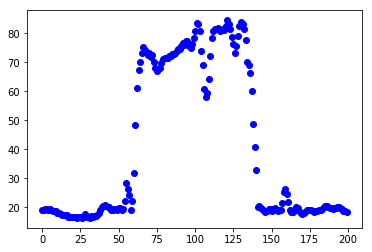

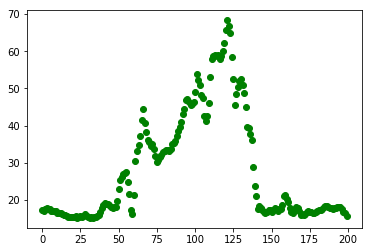

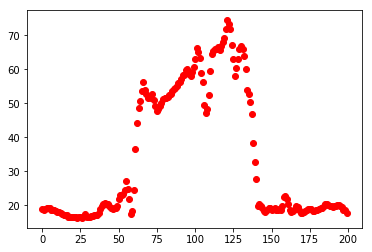

In [36]:
cm01 = CompositeMask('data/Alexander-Wang-spring-2018-look077.jpg')
plot_std_devs(get_std_devs(cm01.image))


In [37]:
from scipy.signal import argrelextrema

im01std_devs = get_std_devs(cm01.image)

x = np.random.random(12)

# for local maxima
argrelextrema(x, np.greater)

# for local minima
argrelextrema(x, np.less)


for color, std_devs in im01std_devs.iteritems():
    local_maxes = argrelextrema(np.array(std_devs), np.greater)
    print local_maxes

(array([  3,   5,  18,  22,  25,  28,  32,  41,  47,  51,  55,  66,  70,
        72,  83,  92,  95, 101, 115, 118, 121, 130, 142, 148, 152, 155,
       159, 166, 174, 181, 186, 189, 193, 198]),)
(array([  3,   9,  19,  22,  25,  28,  32,  41,  55,  66,  72,  82,  95,
       101, 113, 115, 121, 130, 142, 149, 152, 159, 166, 170, 174, 186,
       189, 193]),)
(array([  3,   5,  18,  22,  25,  28,  32,  41,  47,  55,  66,  70,  72,
        95, 101, 115, 121, 130, 142, 149, 152, 155, 159, 166, 175, 186,
       189, 193]),)


In [38]:
def diffs(array):
    diffs = []
    for i, j in zip(array, array[1:]):
        diffs.append(j - i)
    return np.array(diffs)

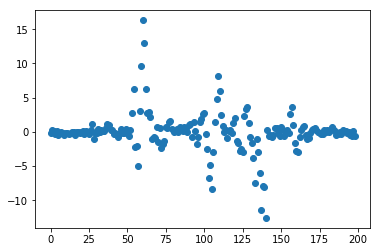

In [39]:
dfs1 = diffs(im01std_devs.values()[0])
plt.scatter(xrange(len(dfs1)), dfs1)
plt.show()


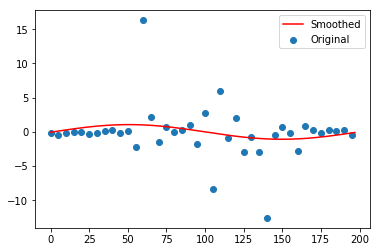

In [40]:
x = np.arange(len(dfs1)) 
y = dfs1
rft = np.fft.rfft(y)
rft[2:] = 0   # Note, rft.shape = 21
y_smooth = np.fft.irfft(rft)


plt.scatter(x[::5], y[::5], label='Original')
plt.plot(x[:-1], y_smooth, label='Smoothed', c='r')
plt.legend(loc=0).draggable()
plt.show()

In [3]:
class CompositeMask():
    def __init__(self, path, threshold = 0.4, num_bg_colors = 16):
        self.load_and_resize_image(path)
        bg_pal = get_background_one_image(path, num_bg_colors)
        self.color_list = [[c[2], c[1], c[0]] for c in bg_pal]
        self.threshold = threshold
        self.make_many_masks()
        self.composite_mask = sum(self.masks)
        self.make_masked_image()
        
    def load_and_resize_image(self, path):
        im = plt.imread(path)
        size = im.shape       
        r = 200.0 / im.shape[1]
        dim = (200, int(im.shape[0] * r))
        resized = cv2.resize(im, dim, interpolation = cv2.INTER_AREA)
        im = rgb_to_bgr(resized)
        self.image = im

    def make_mask(self, three_colors):
        lower = np.array([(c - self.threshold*c)*255 for c in three_colors])
        upper = np.array([(c + self.threshold*c)*255 for c in three_colors])
        shapeMask = cv2.inRange(self.image, lower, upper)
        contoured_img, contours, hierarchy = \
                            cv2.findContours(shapeMask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        return contoured_img
    
    def make_many_masks(self):  
        self.masks = []
        for three_colors in self.color_list:
            self.masks.append(self.make_mask(three_colors))
            
    def plot_many_masks(self):
        num_bg_colors = len(self.masks)
        num_rows = int(num_bg_colors/4) + 1
        subplot_location = 0
        fig = plt.figure(figsize=(10, 12))
        for m in self.masks:
            subplot_location += 1
            ax = fig.add_subplot(num_rows, 4, subplot_location)
            ax.imshow(m)
        plt.tight_layout()
        plt.show()
 
    def make_masked_image(self):
        orig_shape = self.image.shape
        new_image = []
        flat_mask = [p for row in self.composite_mask for p in row]
        flat_image = [p for row in self.image for p in row]
        for m, p in zip(flat_mask, flat_image):
            if m != 0:
                new_image.append(np.array([57, 255, 20]))
            else: new_image.append(p)
        new_image = np.array(new_image)
        new_image = new_image.reshape(orig_shape)
        new_image = new_image.astype('uint8')
        new_image = bgr_to_rgb(new_image)
        self.masked_image = new_image

    def show_masked_image(self):
        im_rgb = self.masked_image
        plt.imshow(im_rgb)
        plt.show()
        
    def show_orig_image(self):
        im_rgb = bgr_to_rgb(self.image)
        plt.imshow(im_rgb)
        plt.show()
  






In [41]:
local_maxes = argrelextrema(y_smooth, np.greater)
local_mins = argrelextrema(y_smooth, np.less)

In [42]:
local_maxes, local_mins

((array([51]),), (array([150]),))

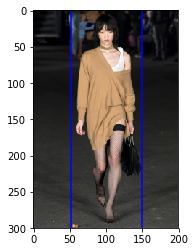

In [43]:
plt.imshow(bgr_to_rgb(cm01.image))
for ix in np.concatenate([local_maxes[0], local_mins[0]]):
    plt.axvline(ix, c='b')
plt.show()

In [44]:
def draw_std_lines(image):
    stds_dict = get_std_devs(image)
    plt.imshow(bgr_to_rgb(image))
    for color, sds in stds_dict.iteritems():
        dfs = diffs(sds)
        y_smooth = smooth_sds(dfs)
        local_extrema = get_local_extrema(y_smooth)
        for ix in local_extrema:
            plt.axvline(ix, c=color)
                
def smooth_sds(std_dev_list):
    rft = np.fft.rfft(std_dev_list)
    rft[2:] = 0
    y_smooth = np.fft.irfft(rft)
    return y_smooth

def get_local_extrema(smoothed_list):
    #this assumes we are doing one max and one min
    lmax = argrelextrema(smoothed_list, np.greater)[0][0]
    lmin = argrelextrema(smoothed_list, np.less)[0][0]
    
    return [lmax, lmin]

def diffs(array):
    diffs = []
    for i, j in zip(array, array[1:]):
        diffs.append(j - i)
    return np.array(diffs)

In [45]:
draw_std_lines(cm01.image)

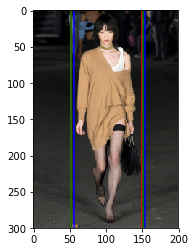

In [46]:
plt.show()

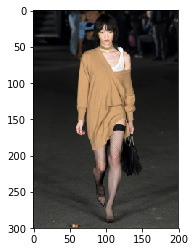

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [48]:
for im in os.listdir('data/'):
    if im.endswith('jpg'):
        cm = CompositeMask('data/' + im)
        cm.show_orig_image()
        plot_std_devs(cm.image)
        

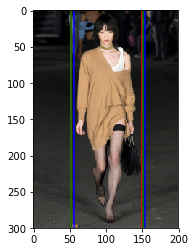

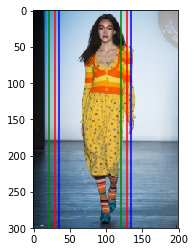

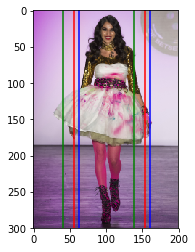

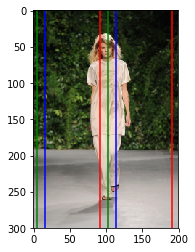

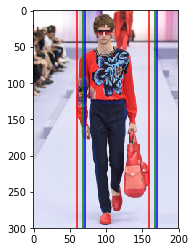

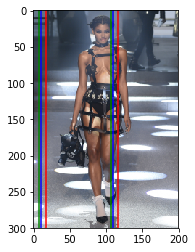

In [47]:
for f in os.listdir('data/'):
    if f.endswith('jpg'):
        cm = CompositeMask('data/' + f)
        draw_std_lines(cm.image)
        plt.show()

In [26]:
def plot_std_devs_top_to_bottom(image):
    color_indicators = ['b', 'g', 'r']
    std_dev_sum = np.zeros(image.shape[0])
    for color, ci in zip(cv2.split(image), color_indicators):
        std_dev_color = []
        count = 0

        for row in color:
            std_dev_color.append(np.std(row))
        std_dev_sum += std_dev_color
        plt.scatter(std_dev_color, xrange(len(std_dev_color)), c=ci)
        plt.gca().invert_yaxis()
        plt.show()
    plt.scatter(std_dev_sum, xrange(len(std_dev_sum)), c='k')
    plt.gca().invert_yaxis()
    plt.show()
    
    

    

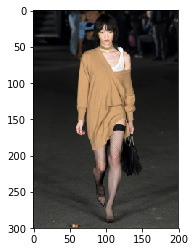

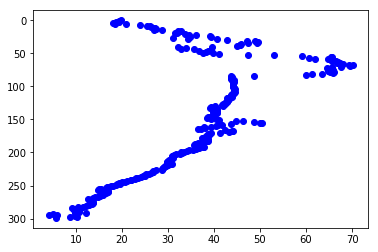

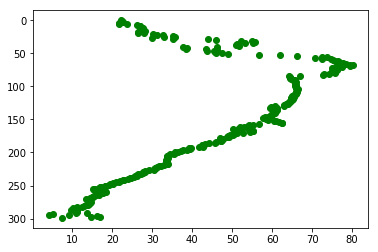

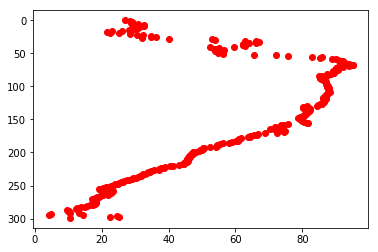

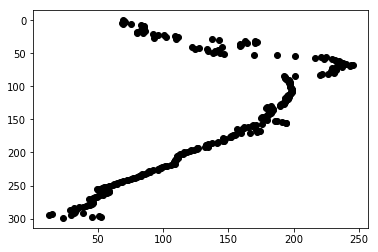

In [27]:
cm01 = CompositeMask('data/Alexander-Wang-spring-2018-look077.jpg')
cm01.show_orig_image()
plot_std_devs_top_to_bottom(cm01.image)

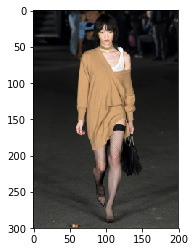

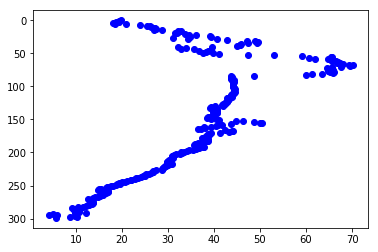

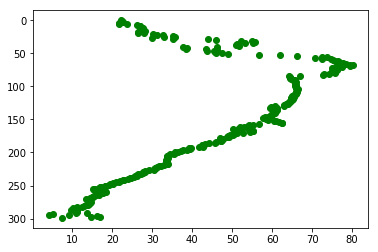

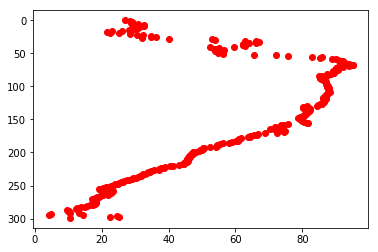

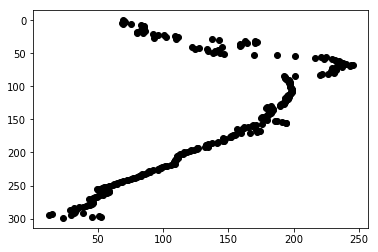

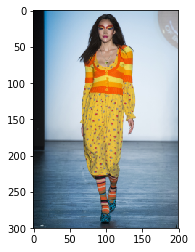

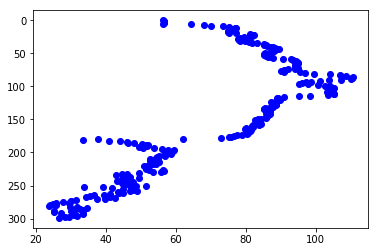

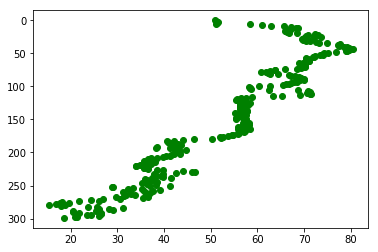

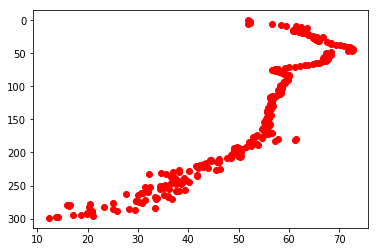

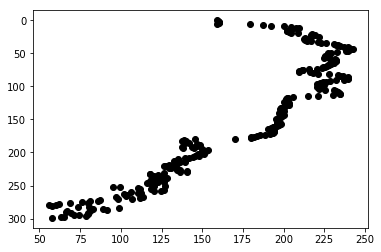

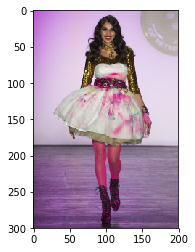

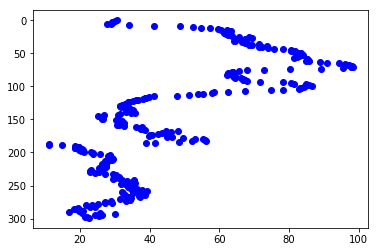

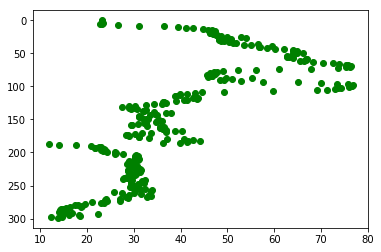

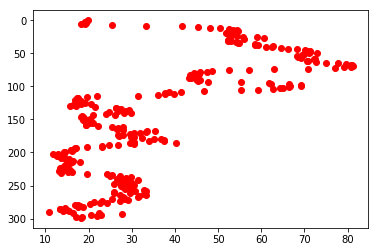

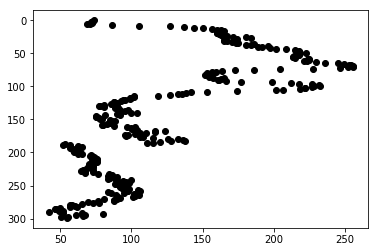

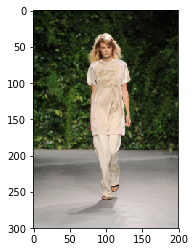

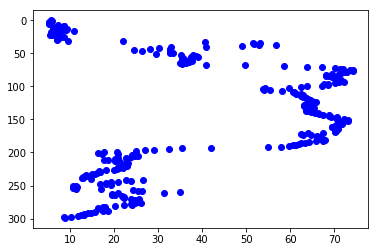

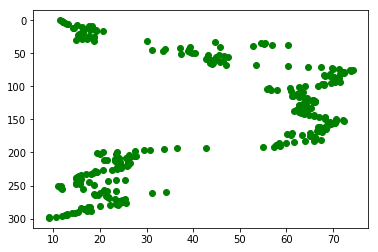

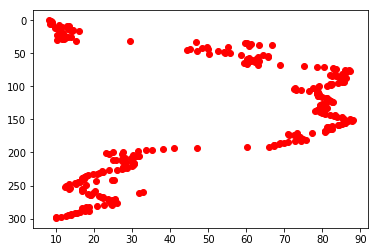

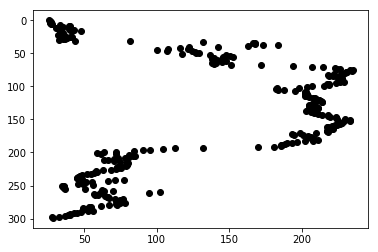

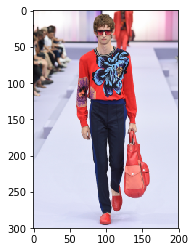

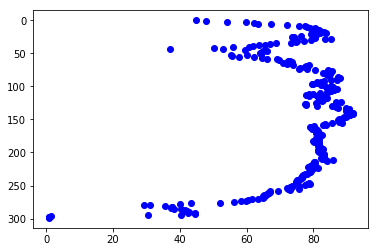

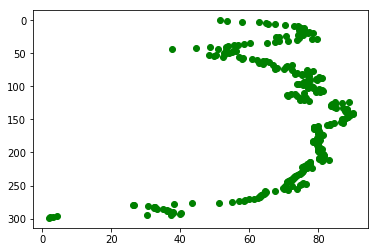

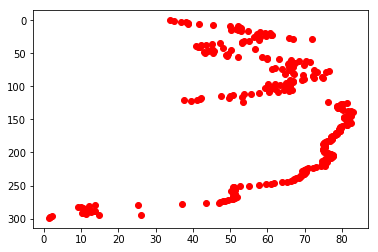

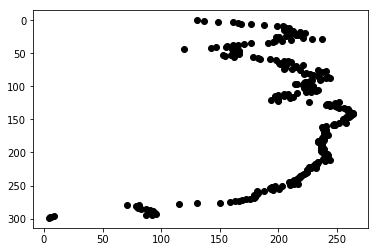

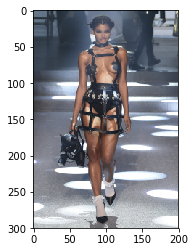

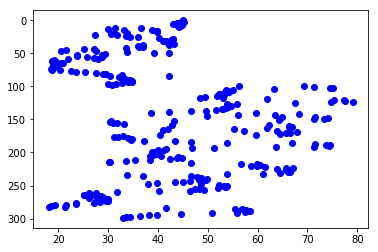

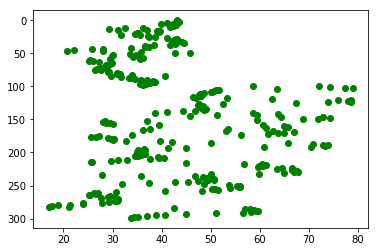

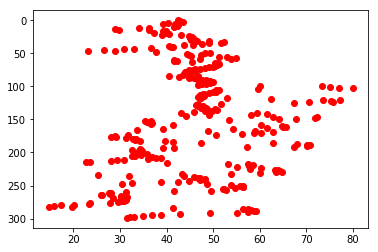

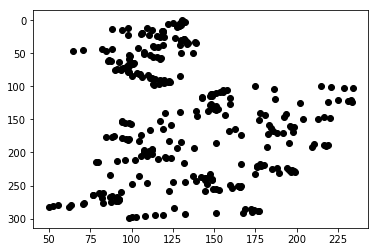

In [28]:
for im in os.listdir('data/'):
    if im.endswith('jpg'):
        cm = CompositeMask('data/' + im)
        cm.show_orig_image()
        plot_std_devs_top_to_bottom(cm.image)
        

In [ ]:
# I want to play with kmeans. Why? Compare this to background sampling. Just take an image and replot is in 32 colors

In [78]:
def flatten_image(image):
    im = np.array(image, dtype=np.float64) / 255    
    w, h, colors = im.shape
    image_flat = np.reshape(im, (w * h, colors))
    return image_flat
    

def kmeans_palette_one_image(image, n_colors, sample_size = 500, seed = 17):
    image = flatten_image(image)        
    if len(image) > sample_size:
        sample_size = len(image)        
    random.seed(seed)
    sample = random.sample(image, sample_size)

    return KMeans(n_clusters=n_colors, random_state=seed).fit(sample)

def assign_kmeans_clusers(image, kmeans_object):
    image = flatten_image(image)    
    predictions = kmeans_object.predict(image)
    return predictions

def assign_colors_to_predictions(kmeans_object, predictions):
    return [kmeans_object.cluster_centers_[ix] for ix in predictions]

def reshape_color_predictions(orig_image, color_predicts):
    w, h, colors = orig_image.shape
    return np.array(color_predicts).reshape(w, h, colors)


In [92]:
kmeans = kmeans_palette_one_image(cm.image, 4)
preds = assign_kmeans_clusers(cm.image, kmeans)

In [93]:
color_preds = assign_colors_to_predictions(kmeans, preds)

In [94]:
kmeans_image = reshape_color_predictions(cm.image, color_preds)


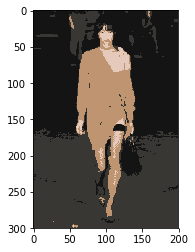

In [95]:
plt.imshow(bgr_to_rgb(kmeans_image))
plt.show()

In [96]:
def make_kmeans_image(image, num_cols):
    kmeans = kmeans_palette_one_image(image, num_cols)
    preds = assign_kmeans_clusers(image, kmeans)
    color_preds = assign_colors_to_predictions(kmeans, preds)
    kmeans_image = reshape_color_predictions(image, color_preds)
    plt.imshow(bgr_to_rgb(kmeans_image))

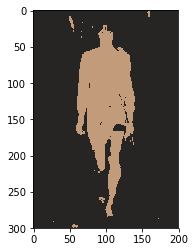

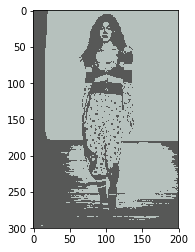

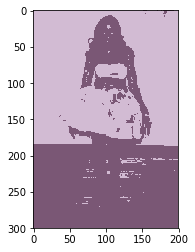

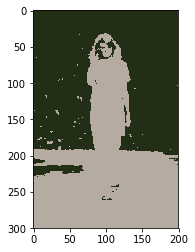

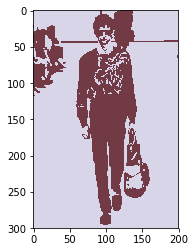

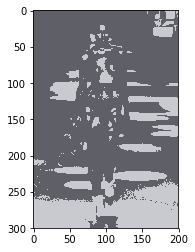

In [98]:
for f in os.listdir('data/'):
    if f.endswith('jpg'):
        cm = CompositeMask('data/' + f)
        make_kmeans_image(cm.image, 2)
        plt.show()

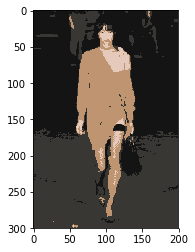

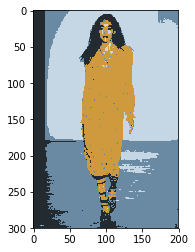

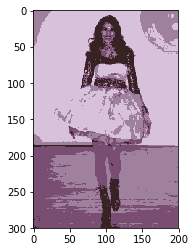

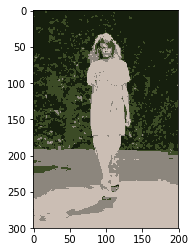

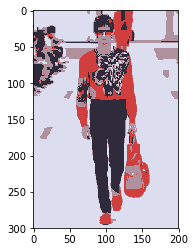

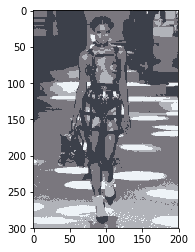

In [99]:
for f in os.listdir('data/'):
    if f.endswith('jpg'):
        cm = CompositeMask('data/' + f)
        im = make_kmeans_image(cm.image, 4)
        print type(im)
        plt.show()

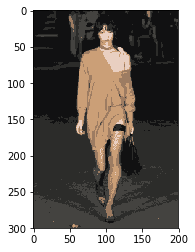

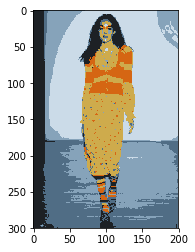

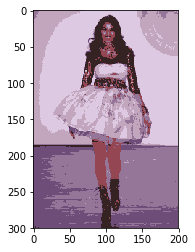

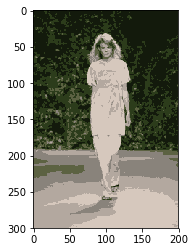

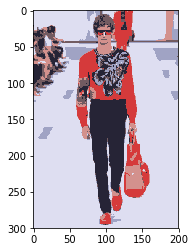

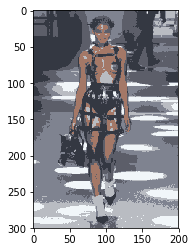

In [100]:
for f in os.listdir('data/'):
    if f.endswith('jpg'):
        cm = CompositeMask('data/' + f)
        make_kmeans_image(cm.image, 6)
        plt.show()

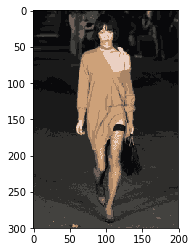

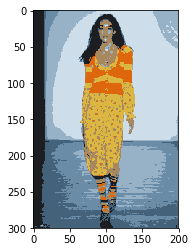

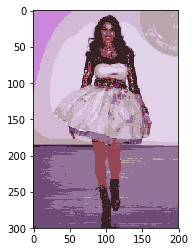

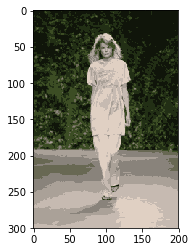

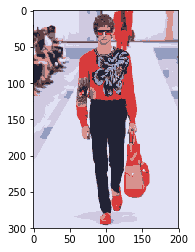

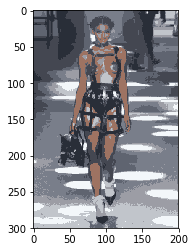

In [101]:
for f in os.listdir('data/'):
    if f.endswith('jpg'):
        cm = CompositeMask('data/' + f)
        make_kmeans_image(cm.image, 8)
        plt.show()

(300, 200)


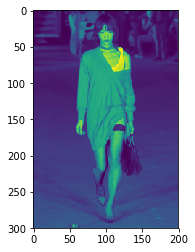

(300, 200)


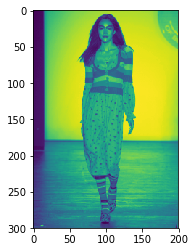

(300, 200)


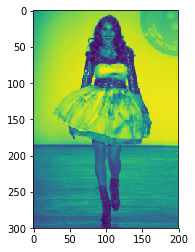

(300, 200)


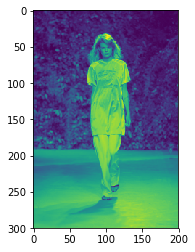

(300, 200)


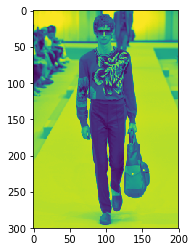

(300, 200)


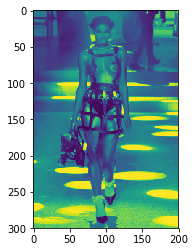

In [104]:
for f in os.listdir('data/'):
    if f.endswith('jpg'):
        cm = CompositeMask('data/' + f)
        grey_image = cv2.cvtColor(cm.image, cv2.COLOR_RGB2GRAY)
        print grey_image.shape
        plt.imshow(grey_image)
        plt.show()